## GAN starter code
Corresponding tutorial: [https://youtu.be/_pIMdDWK5sc](https://youtu.be/_pIMdDWK5sc)

In [1]:
!pip install pytorch-lightning

In [2]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [4]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [5]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [11]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        self.validation_z = torch.randn(6, self.hparams.latent_dim)  # Generate only 6 images for visualization

        # Disable automatic optimization (needed for multiple optimizers)
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch

        # Get optimizers manually
        opt_g, opt_d = self.optimizers()

        # Sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim).type_as(real_imgs)

        # === Train Generator ===
        self.toggle_optimizer(opt_g)  # Lock D, train G
        fake_imgs = self(z)
        y_hat = self.discriminator(fake_imgs)
        y = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        g_loss = self.adversarial_loss(y_hat, y)

        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()
        self.untoggle_optimizer(opt_g)  # Unlock D

        # === Train Discriminator ===
        self.toggle_optimizer(opt_d)  # Lock G, train D
        y_hat_real = self.discriminator(real_imgs)
        y_real = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        real_loss = self.adversarial_loss(y_hat_real, y_real)

        y_hat_fake = self.discriminator(fake_imgs.detach())
        y_fake = torch.zeros(real_imgs.size(0), 1).type_as(real_imgs)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        d_loss = (real_loss + fake_loss) / 2

        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()
        self.untoggle_optimizer(opt_d)  # Unlock G

        # Logging
        self.log("g_loss", g_loss, prog_bar=True, on_epoch=True)
        self.log("d_loss", d_loss, prog_bar=True, on_epoch=True)

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d]

    def plot_imgs(self):
        """ Generates and plots 6 images to monitor training progress """
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).detach().cpu()  # Ensure no gradients before plotting

        print(f"Epoch {self.current_epoch} - Generated Images")

        fig, axes = plt.subplots(2, 3, figsize=(6, 4))  # Fixed 2x3 grid
        axes = axes.flatten()

        for i in range(6):  # Ensure only 6 images are plotted
            axes[i].imshow(sample_imgs[i, 0, :, :], cmap='gray_r', interpolation='none')
            axes[i].set_title(f"Image {i+1}")
            axes[i].axis("off")  # Hide axis for clean visualization

        plt.tight_layout()
        plt.show()

    def on_train_epoch_end(self):
        """ Plots generated images after every 5 epochs """
        if self.current_epoch % 5 == 0:
            self.plot_imgs()

    


In [7]:
dm = MNISTDataModule()
model = GAN()


Epoch 0 - Generated Images


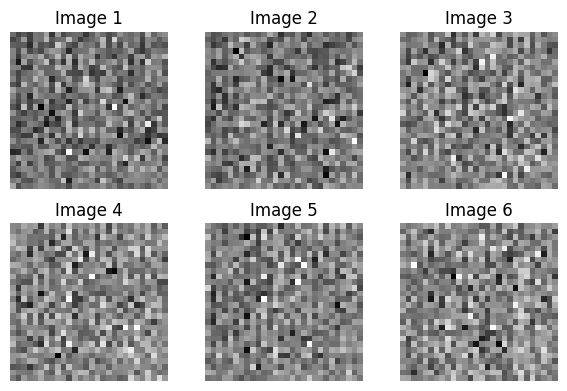

In [8]:
model.plot_imgs()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 428kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.97MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.91MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 - Generated Images


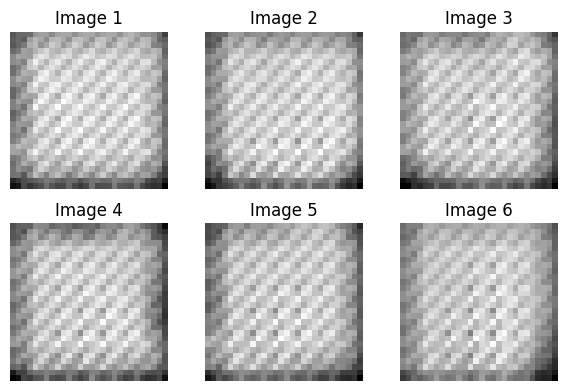

Epoch 5 - Generated Images


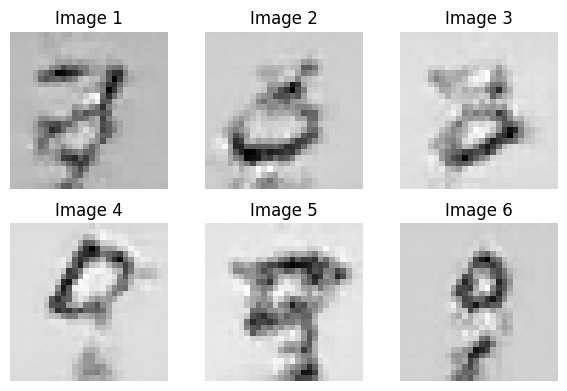

Epoch 10 - Generated Images


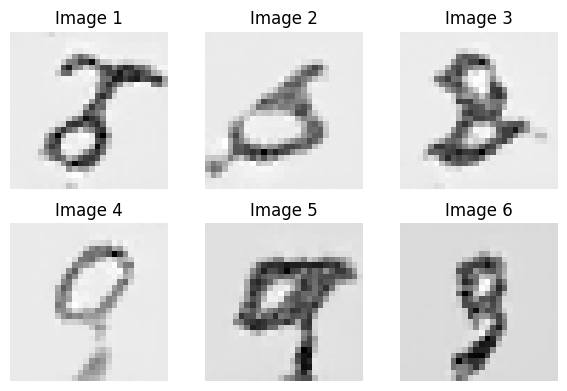

Epoch 15 - Generated Images


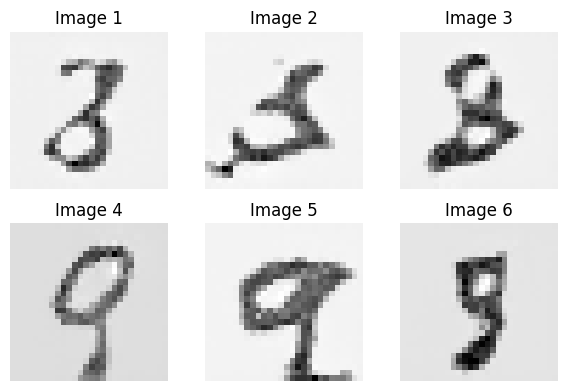

Epoch 20 - Generated Images


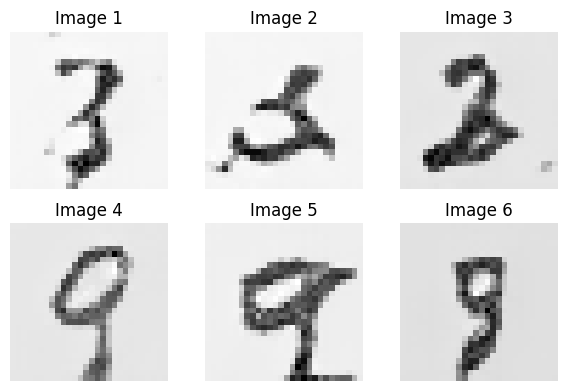

Epoch 25 - Generated Images


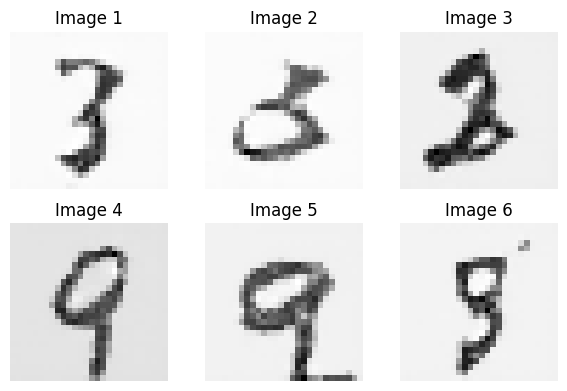

Epoch 30 - Generated Images


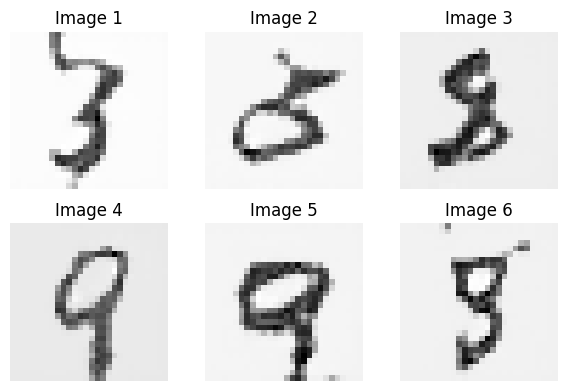

Epoch 35 - Generated Images


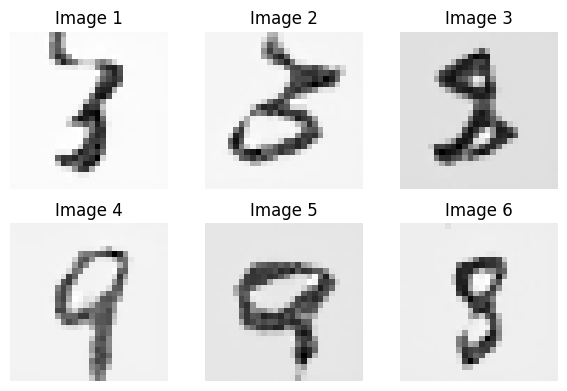

Epoch 40 - Generated Images


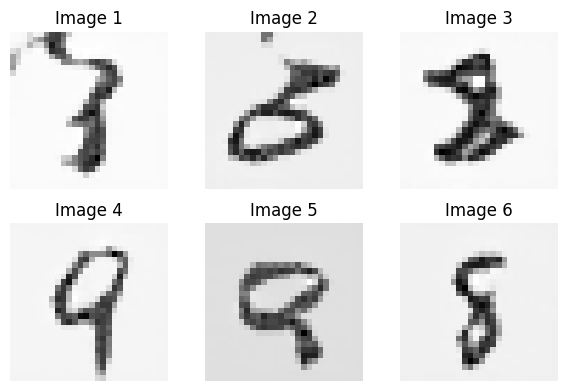

Epoch 45 - Generated Images


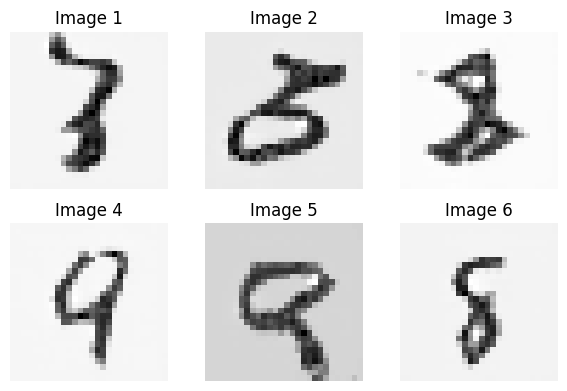

In [9]:
trainer = pl.Trainer(max_epochs=50, accelerator='gpu', devices='auto')
trainer.fit(model, dm)

In [12]:
def test_generator(model, latent_dim=100):
    """ Generates and displays a single image from random noise using the trained generator. """
    
    model.eval()  # Set the model to evaluation mode

    # Generate random noise (latent vector)
    z = torch.randn(1, latent_dim).to(model.device)

    # Generate image
    with torch.no_grad():
        generated_img = model.generator(z).cpu()  # Move to CPU for visualization

    # Convert tensor to image
    generated_img = generated_img.squeeze(0).squeeze(0)  # Remove batch & channel dimensions

    # Display the generated image
    plt.imshow(generated_img, cmap='gray_r', interpolation='none')
    plt.title("Generated Number")
    plt.axis("off")
    plt.show()

# Example usage:
# Assuming 'gan_model' is your trained GAN instance



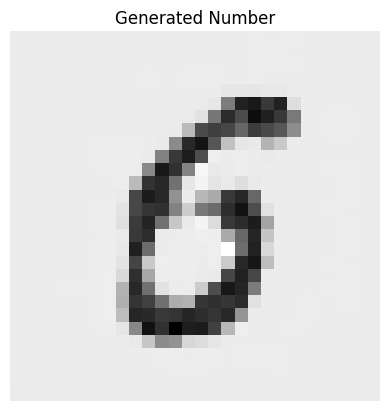

In [15]:
test_generator(model, latent_dim=100)